<a href="https://colab.research.google.com/github/Oksana0020/DL-with-PyTorch/blob/main/Building_blocks_of_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports + Device

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Plotting helper functions

In [8]:
def plot_image(image_tensor, title=""):
    """
    Plots a single 2D image tensor (H, W) or (1, H, W).
    Ensures tensor is on CPU and detached.
    """
    img = image_tensor.detach().cpu()
    if img.ndim == 3 and img.shape[0] == 1:
        img = img[0]
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()


def plot_feature_maps(feature_maps_tensor, num_cols=3, main_title="Feature Maps"):
    """
    Plots multiple feature maps in a grid.
    Expects tensor shape: (num_maps, height, width)
    """
    fm = feature_maps_tensor.detach().cpu()
    num_maps = fm.shape[0]

    if num_maps < num_cols:
        num_cols = num_maps
    num_rows = (num_maps + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3.5))
    if num_maps == 1:
        axes = [axes]
    else:
        axes = np.array(axes).flatten()

    fig.suptitle(main_title, fontsize=16)

    for i in range(num_maps):
        ax = axes[i]
        ax.imshow(fm[i].numpy(), cmap="gray")
        ax.set_title(f"Map {i+1}")
        ax.axis("off")

    # Turn off unused axes
    for j in range(num_maps, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Manual convolution on a tiny image

Original Sample Image:
 tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Convolutional Filter:
 tensor([[ 1.,  0.],
        [ 0., -1.]])

Output Feature Map (after convolution):
 tensor([[-4., -4.],
        [-4., -4.]], grad_fn=<SqueezeBackward0>)


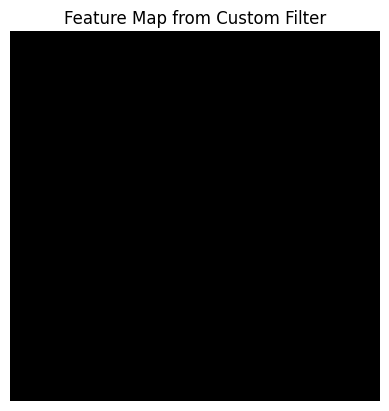

In [9]:
# Sample 3x3 image
sample_image_data = torch.tensor([[1, 2, 3],
                                  [4, 5, 6],
                                  [7, 8, 9]], dtype=torch.float32)

# A simple diagonal/edge-ish 2x2 filter
conv_filter_data = torch.tensor([[1, 0],
                                 [0, -1]], dtype=torch.float32)

# Create Conv2d: in_channels=1, out_channels=1, kernel_size=2x2
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)

# Set weights manually
with torch.no_grad():
    conv_layer.weight[0, 0] = conv_filter_data  # shape (out_ch, in_ch, kH, kW)

# Prepare input (batch=1, channels=1, H=3, W=3)
sample_image_tensor = sample_image_data.view(1, 1, 3, 3)

# Apply convolution
output_feature_map = conv_layer(sample_image_tensor)

print("Original Sample Image:\n", sample_image_data)
print("\nConvolutional Filter:\n", conv_filter_data)
print("\nOutput Feature Map (after convolution):\n", output_feature_map.squeeze())

# Visualize output feature map (remove batch/channel dims)
plot_image(output_feature_map.squeeze(), title="Feature Map from Custom Filter")


Step 3: SimpleConvNet + visualize feature maps

Shape of conv1 weights: torch.Size([3, 1, 3, 3])
Shape of conv1 bias: torch.Size([3])
Output from model shape: torch.Size([1, 3, 3, 3])


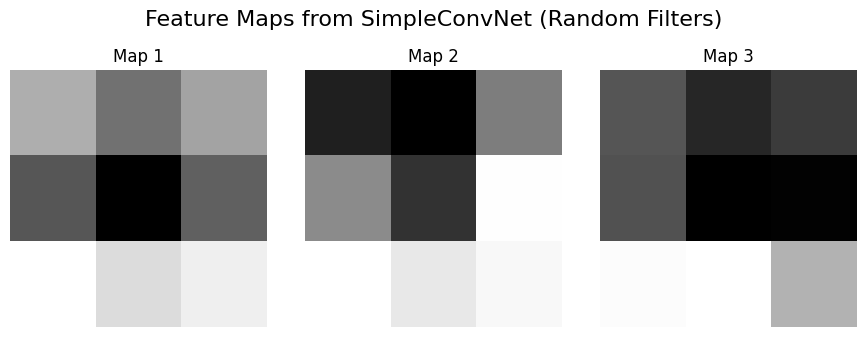

In [10]:

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # 1 input channel (grayscale), 3 output channels, 3x3 kernel
        # stride=1, padding=1 keeps spatial size same
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        return x


model_simple = SimpleConvNet()
print("Shape of conv1 weights:", model_simple.conv1.weight.shape)  # (out_ch, in_ch, kH, kW)
if model_simple.conv1.bias is not None:
    print("Shape of conv1 bias:", model_simple.conv1.bias.shape)   # (out_ch,)

model_simple.eval()

with torch.no_grad():
    # reuse sample_image_tensor from Step 2 (shape 1,1,3,3)
    out = model_simple(sample_image_tensor)  # (1,3,3,3)

print("Output from model shape:", out.shape)

# For plotting: remove batch dimension => (3,3,3)
feature_maps_viz = out.squeeze(0)
plot_feature_maps(feature_maps_viz, num_cols=3, main_title="Feature Maps from SimpleConvNet (Random Filters)")


MNIST data loaders

In [11]:
batch_size_train = 64
batch_size_test = 1000

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]

Train size: 60000 Test size: 10000


Execute Training

In [12]:

for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.411280
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.412868
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.489289
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.295601
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.230002
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.398234
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.193731
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.315578
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.200475
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.150070

Test set: Average loss: 0.2934, Accuracy: 9138/10000 (91.38%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.272700
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.390284
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.239744
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.340405
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.472453
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.485126
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.256759
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.196962
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.17051

CNN model for MNIST

In [13]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(2, 2)                # 28x28 -> 14x14
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Train + Test functions (FIXED)
#   - test() does NOT append to accuracy_list
#   - returns preds/targets for confusion matrix

In [16]:
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        total += data.size(0)

    avg_loss = running_loss / total
    return avg_loss


def test():
    model.eval()
    test_loss = 0.0
    correct = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)

            correct += pred.eq(target).sum().item()
            all_preds.append(pred.detach().cpu().numpy())
            all_targets.append(target.detach().cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return test_loss, accuracy, all_preds, all_targets


Train loop + logging lists

In [17]:
epochs = 5

train_losses = []
train_counter = []
accuracy_list = []

seen = 0

for epoch in range(1, epochs + 1):
    avg_loss = train_one_epoch(epoch)
    train_losses.append(avg_loss)

    seen += len(train_loader.dataset)
    train_counter.append(seen)

    test_loss, accuracy, _, _ = test()
    accuracy_list.append(accuracy)

    print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_loss:.4f} | Test Loss: {test_loss:.4f} | Acc: {accuracy:.2f}%")

print("Lengths -> epochs:", epochs, "accuracy_list:", len(accuracy_list))


Epoch 1/5 | Train Loss: 0.0481 | Test Loss: 0.0364 | Acc: 98.86%
Epoch 2/5 | Train Loss: 0.0377 | Test Loss: 0.0381 | Acc: 98.91%
Epoch 3/5 | Train Loss: 0.0284 | Test Loss: 0.0288 | Acc: 99.11%
Epoch 4/5 | Train Loss: 0.0244 | Test Loss: 0.0311 | Acc: 99.04%
Epoch 5/5 | Train Loss: 0.0208 | Test Loss: 0.0311 | Acc: 99.04%
Lengths -> epochs: 5 accuracy_list: 5


Visualize predictions (MNIST)

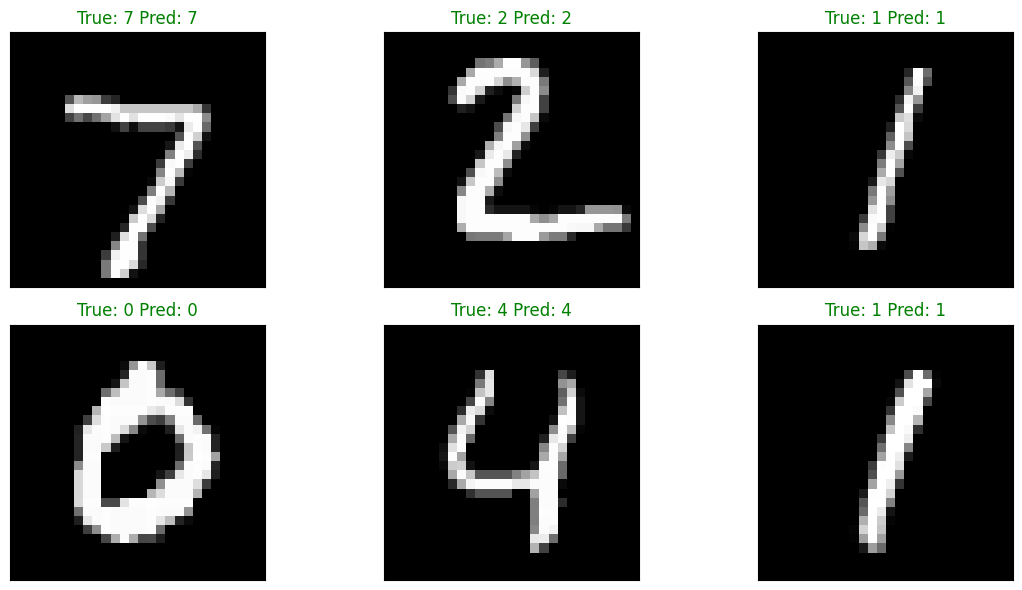

In [18]:

def visualize_predictions(num_images=6):
    model.eval()
    with torch.no_grad():
        data, target = next(iter(test_loader))
        data, target = data.to(device), target.to(device)

        output = model(data)
        pred = output.argmax(dim=1)

        fig = plt.figure(figsize=(12, 6))
        for idx in range(num_images):
            ax = fig.add_subplot(2, 3, idx + 1)
            ax.imshow(data[idx][0].detach().cpu(), cmap='gray')
            color = 'green' if pred[idx].item() == target[idx].item() else 'red'
            ax.set_title(f"True: {target[idx].item()} Pred: {pred[idx].item()}", color=color)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()

visualize_predictions()


Plot training loss

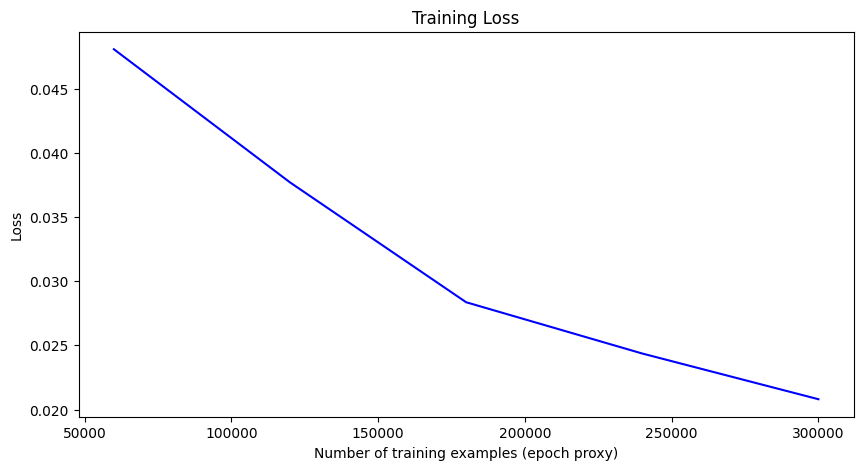

In [19]:

plt.figure(figsize=(10, 5))
plt.plot(train_counter, train_losses, color='blue')
plt.xlabel('Number of training examples (epoch proxy)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Plot accuracy progression (FIXED)

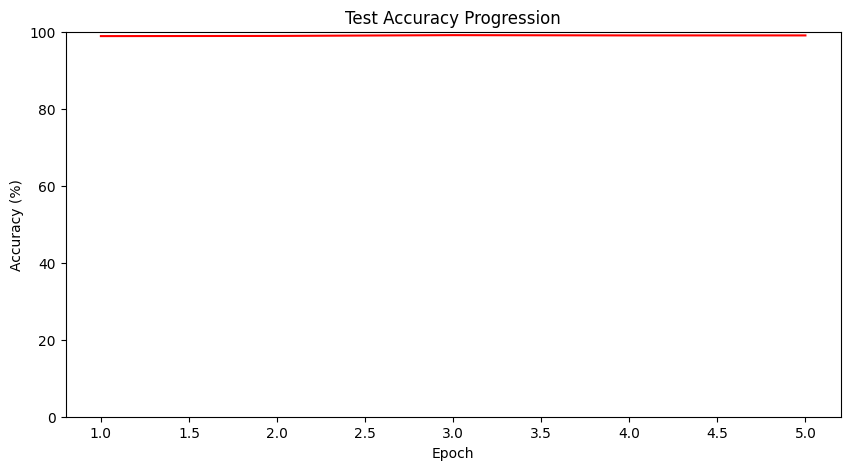

In [20]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), accuracy_list, color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Progression')
plt.ylim(0, 100)
plt.show()


Confusion matrix + per-class accuracy

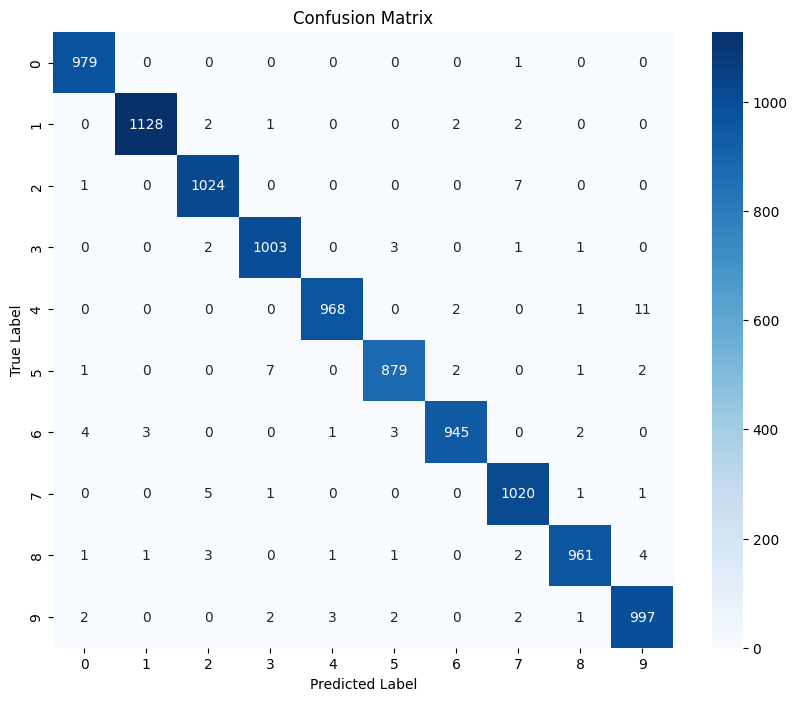

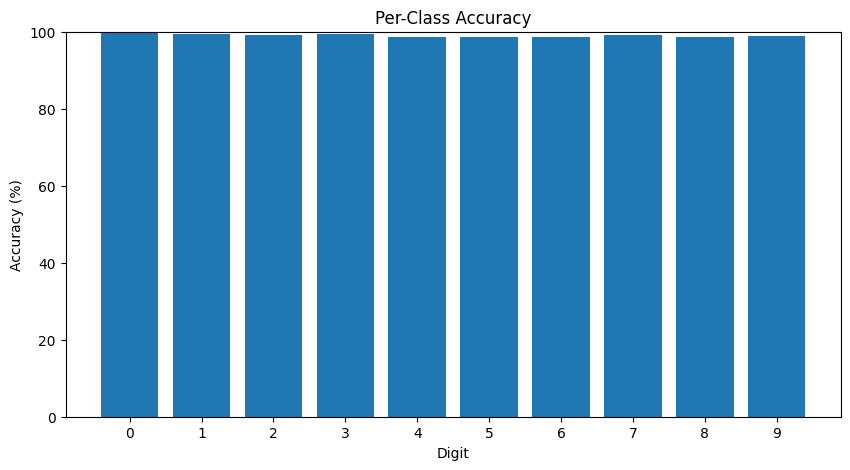

In [21]:

def plot_confusion_matrix(preds, targets):
    cm = confusion_matrix(targets, preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    per_class_accuracy = 100 * np.diag(cm) / np.sum(cm, axis=1)

    plt.figure(figsize=(10, 5))
    plt.bar(range(10), per_class_accuracy)
    plt.xlabel('Digit')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-Class Accuracy')
    plt.xticks(range(10))
    plt.ylim(0, 100)
    plt.show()


_, _, all_preds, all_targets = test()
plot_confusion_matrix(all_preds, all_targets)
